Analysis Titan's winning 921 blocks.

Author: Bryanzk
Date Modified: 2024.04.11
License: CC0

In [3]:
from data_prep_utils import *

df = get_block_data_with_winning_bids_having_bid_ts()
dft = get_titan_won_921_blocks_bidding_data()
df_builder_info = get_builder_info(df)

print(df.columns)

/Users/kezheng/temp/mevboost-data/examples/data_prep_utils.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2023-10-10 12:17:46.267000', '2023-10-10 12:17:59.157000',
 '2023-10-10 12:18:11.103000', '2023-10-10 12:18:23.431000',
 '2023-10-10 12:18:35.193000', '2023-10-10 12:18:47.158000',
 '2023-10-10 12:18:59.140000', '2023-10-10 12:19:11.045000',
 '2023-10-10 12:19:23.192000', '2023-10-10 12:19:47.657000',
 ...
 '2024-04-09 18:52:47.037000', '2024-04-09 18:52:59.769000',
 '2024-04-09 18:53:11.636000', '2024-04-09 18:53:23.926000',
 '2024-04-09 18:53:35.903000', '2024-04-09 18:53:59.772000',
 '2024-04-09 18:54:11.705000', '2024-04-09 18:54:23.194000',
 '2024-04-09 18:54:35.642000', '2024-04-09 18:54:47.768000']
Length: 1140830, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df['bid_

Index(['block_datetime', 'slot', 'block_number', 'block_hash', 'value',
       'base_fee_per_gas', 'gas_limit', 'gas_used', 'num_tx', 'builder_label',
       'builder_pubkey', 'relay', 'bid_timestamp_ms', 'slot_time_ms',
       'proposer_pubkey', 'proposer_mev_recipient', 'optimistic_submission',
       'builder_fee_recipient', 'block_timestamp', 'extra_data',
       'payload_delivered', 'org_bid_timestamp_ms', 'ts_diff', 'ts_diff_secs'],
      dtype='object')


In [4]:
# Filter out the duplicate block_number records with the earliest bid_timestamp, which is the winning bid thru the fastest relay
# N.B.: this would omit the records with the same block_number but different bid_timestamp from differe relays
df_filtered = df.copy()
df_filtered = df_filtered.sort_values(['block_number', 'bid_timestamp_ms'])
df_filtered = df_filtered.drop_duplicates('block_number', keep='first')

# get the unique block numbers won by Titan
unique_block_numbers_won_by_titan = dft['block_number'].unique()

df_filtered_titan = df_filtered[df_filtered['block_number'].isin(unique_block_numbers_won_by_titan)]
# df_filtered_titan.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df_filtered['bid_timestamp_ms'], unit='ms')
print(df_filtered_titan.shape[0])

921


min:-3.0; max:3.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_37841/3125691299.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(0.2, 0.3], (-0.2, -0.1], (2.66e-15, 0.1], (-0.4, -0.3], (-0.7, -0.6], ..., (-0.8, -0.7], (-0.2, -0.1], (-0.7, -0.6], (-0.3, -0.2], (-0.4, -0.3]]
Length: 921
Categories (60, interval[float64, right]): [(-3.0, -2.9] < (-2.9, -2.8] < (-2.8, -2.7] < (-2.7, -2.6] ... (2.6, 2.7] < (2.7, 2.8] < (2.8, 2.9] < (2.9, 3.0]]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_37841/3125691299.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(0.2, 0.3], (-0.2, -0.1], (0.0, 0.1], (-0.4, -0.3], (-0.7, -0.6], ..., (-0.8, -0.7], (-0.2, -0.1], (-0.7, -0.6], (-0.3, -0.2], (-0.4, -0.3

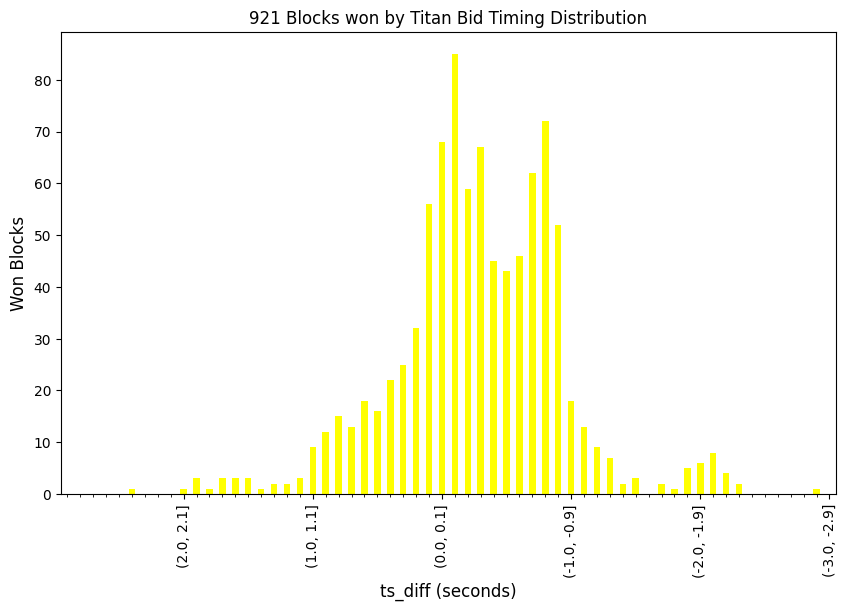

In [6]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


# 计算 ts_diff 的最小和最大值
x_min = np.floor(df_filtered_titan['ts_diff_secs'].min())
x_max = np.ceil(df_filtered_titan['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
    df_filtered_titan['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)


df_filtered_titan.loc[:,'ts_diff_bins'] = df_filtered_titan['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))


grouped = df_filtered_titan.groupby('ts_diff_bins')['block_number'].count()

ax = grouped.plot(kind='bar', figsize=(10,6), color='yellow')

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))  # 设置主要刻度为1秒
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1))   # 设置次要刻度为0.1秒

# 逆转x轴
ax.invert_xaxis()

plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Won Blocks', fontsize=12)
plt.title('921 Blocks won by Titan Bid Timing Distribution')

plt.show()
